# Milestone 2

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# import sklearn

## Load data

In [3]:
# Use this path if you aren't using colab:
# base_path = './detection+of+iot+botnet+attacks+n+baiot/'
base_path = 'data/'

folders = ['SimpleHome_XCS7_1003_WHT_Security_Camera', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'Provision_PT_838_Security_Camera', 'Provision_PT_737E_Security_Camera', 'Philips_B120N10_Baby_Monitor', 'Ennio_Doorbell', 'Ecobee_Thermostat', 'Danmini_Doorbell']

# 1. Load benign traffic
benign_traffic = pd.DataFrame()
for folder in folders:
  curr_csv = pd.read_csv(base_path + folder + '/benign_traffic.csv')
  curr_csv['Device'] = folder
  benign_traffic = pd.concat([benign_traffic, curr_csv])
# benign_traffic1 = pd.read_csv(base_path + 'SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv')
# benign_traffic2 = pd.read_csv(base_path + 'Samsung_SNH_1011_N_Webcam/benign_traffic.csv')
# benign_traffic = pd.concat([benign_traffic1, benign_traffic2])
benign_traffic

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Device
0,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,SimpleHome_XCS7_1003_WHT_Security_Camera
1,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,1.061357,60.000000,9.540000e-07,60.000000,9.090000e-13,0.000000e+00,0.000000e+00,SimpleHome_XCS7_1003_WHT_Security_Camera
2,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,1.000000,60.000000,0.000000e+00,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,SimpleHome_XCS7_1003_WHT_Security_Camera
3,1.000000,590.0,0.000000e+00,1.000000,590.0,0.000000e+00,1.000000,590.000000,0.000000,1.000000,...,0.000000e+00,0.0,5.832783,388.850426,9.199164e+01,388.850426,8.462461e+03,0.000000e+00,0.000000e+00,SimpleHome_XCS7_1003_WHT_Security_Camera
4,1.927179,590.0,0.000000e+00,1.955648,590.0,0.000000e+00,1.984992,590.000000,0.000000,1.998489,...,0.000000e+00,0.0,6.831901,418.293119,1.108120e+02,418.293119,1.227931e+04,0.000000e+00,0.000000e+00,SimpleHome_XCS7_1003_WHT_Security_Camera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49543,1.000000,102.0,0.000000e+00,1.000000,102.0,1.820000e-12,1.000009,101.999633,0.015405,2.270210,...,-1.570000e-30,0.0,4.218824,102.000000,0.000000e+00,144.249783,1.820000e-12,5.970000e-23,0.000000e+00,Danmini_Doorbell
49544,1.999976,102.0,0.000000e+00,1.999986,102.0,1.820000e-12,2.000004,101.999816,0.007702,3.270209,...,-1.580000e-44,0.0,4.218838,102.000000,0.000000e+00,144.249783,3.640000e-12,-1.100000e-29,0.000000e+00,Danmini_Doorbell
49545,2.999872,102.0,3.640000e-12,2.999923,102.0,1.820000e-12,2.999983,101.999878,0.005135,4.270206,...,-8.330000e-45,0.0,4.179949,102.000000,1.910000e-06,144.249783,5.140000e-12,8.230000e-29,2.260000e-17,Danmini_Doorbell
49546,3.999664,102.0,3.640000e-12,3.999798,102.0,0.000000e+00,3.999942,101.999908,0.003851,5.270200,...,4.980000e-69,0.0,4.219537,102.000000,1.350000e-06,144.249783,1.820000e-12,5.960000e-29,0.000000e+00,Danmini_Doorbell


In [ ]:
# RUN ONCE FOR EXTRACTION below are prereqs
# pip install patool
# winget install --id 7zip.7zip
import patoolib

In [ ]:
#RUN ONCE FOR EXTRACTION!!

for folder in folders:
  gafgyt_path = base_path + folder + "/gafgyt_attacks.rar"
  mirai_path = base_path + folder + "/mirai_attacks.rar"
  
  if os.path.exists(gafgyt_path):
    patoolib.extract_archive(gafgyt_path, outdir=base_path + folder + "/gafgyt_attacks/")
  
  if os.path.exists(mirai_path):
    patoolib.extract_archive(mirai_path, outdir=base_path + folder + "/mirai_attacks/")



INFO patool: Extracting data/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks.rar ...
INFO patool: ... creating output directory `data/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/'.
INFO patool: running "C:\Program Files\WinRAR\rar.EXE" x -kb -or -- c:\Users\pazmo\Desktop\everything\Projects\CSE151A\CSE151A-Project\data\SimpleHome_XCS7_1003_WHT_Security_Camera\gafgyt_attacks.rar
INFO patool: ... data/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks.rar extracted to `data/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/'.
INFO patool: Extracting data/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks.rar ...
INFO patool: ... creating output directory `data/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/'.
INFO patool: running "C:\Program Files\WinRAR\rar.EXE" x -kb -or -- c:\Users\pazmo\Desktop\everything\Projects\CSE151A\CSE151A-Project\data\SimpleHome_XCS7_1003_WHT_Security_Camera\mirai_attacks.rar
INFO patool: ... data/SimpleHome_XCS7_100

In [3]:
test = pd.read_csv(base_path+folders[2]+'/gafgyt_attacks/junk.csv')
test

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
0,1.000000,98.000000,0.000000,1.000000,98.000000,0.000000e+00,1.000000,98.000000,0.000000e+00,1.000000,...,0.000000e+00,0.0,0.0,1.000000,98.0,0.000000e+00,98.000000,0.000000e+00,0.0,0.0
1,1.029191,98.000000,0.000000,1.119992,98.000000,1.818989e-12,1.493231,98.000000,3.637979e-12,1.931762,...,0.000000e+00,0.0,0.0,1.992957,98.0,0.000000e+00,138.592929,0.000000e+00,0.0,0.0
2,1.077270,68.295282,68.180692,1.236877,72.128396,1.585514e+02,1.889672,81.065843,2.551274e+02,2.834273,...,0.000000e+00,0.0,0.0,1.000000,66.0,0.000000e+00,114.039467,0.000000e+00,0.0,0.0
3,2.038100,71.094319,42.860737,2.209694,72.975393,8.766659e+01,2.875726,78.608779,1.777339e+02,3.832174,...,0.000000e+00,0.0,0.0,1.000000,74.0,0.000000e+00,74.000000,0.000000e+00,0.0,0.0
4,3.000117,72.062842,30.450564,3.184892,73.297101,6.036696e+01,3.864926,77.416316,1.358213e+02,4.830732,...,0.000000e+00,0.0,0.0,1.000000,74.0,0.000000e+00,74.000000,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28300,163.002961,74.132261,3.156770,273.300355,74.091494,2.187882e+00,759.282825,74.060869,5.117341e+00,6723.413700,...,0.000000e+00,0.0,0.0,1.682391,74.0,9.536743e-07,95.268043,9.094947e-13,0.0,0.0
28301,163.062862,74.131450,3.137517,273.353526,74.091160,2.179909e+00,759.404984,74.060789,5.110607e+00,6723.635971,...,0.000000e+00,0.0,0.0,1.682383,74.0,9.536743e-07,95.268043,9.094947e-13,0.0,0.0
28302,164.058954,74.130649,3.118497,274.349596,74.090827,2.171993e+00,760.401344,74.060709,5.103891e+00,6724.632748,...,1.818989e-12,0.0,0.0,1.682383,74.0,1.348699e-06,95.268043,1.818989e-12,0.0,0.0
28303,163.596838,74.129850,3.099539,273.879945,74.090496,2.164093e+00,760.041126,74.060629,5.097181e+00,6724.428866,...,0.000000e+00,0.0,0.0,1.682371,74.0,0.000000e+00,95.268043,0.000000e+00,0.0,0.0


In [4]:
# Load ALL attack data from all devices and both attack types

# 2. Load attack traffic (gafgyt and mirai)
attack_traffic = pd.DataFrame()
temp = pd.DataFrame()
print("Loading attack data...")
for folder in folders:
    print(f"Processing {folder}...")
    temp = pd.DataFrame()
    # Check gafgyt attacks folder
    gafgyt_folder = base_path + folder + '/gafgyt_attacks/'
    if os.path.exists(gafgyt_folder):
        gafgyt_files = [f for f in os.listdir(gafgyt_folder) if f.endswith('.csv')]
        print(f"  Found {len(gafgyt_files)} gafgyt CSV files")
        
        for csv_filename in gafgyt_files:
            csv_file = gafgyt_folder + csv_filename
            curr_csv = pd.read_csv(csv_file)
            curr_csv['Device'] = folder
            curr_csv['Botnet_Type'] = 'gafgyt'
            curr_csv['Attack_Type'] = csv_filename
            temp = pd.concat([temp, curr_csv])
            print(f"    Added {csv_filename} - {len(curr_csv)} rows")
    
    # Check mirai attacks folder  
    mirai_folder = base_path + folder + '/mirai_attacks/'
    if os.path.exists(mirai_folder):
        mirai_files = [f for f in os.listdir(mirai_folder) if f.endswith('.csv')]
        print(f"  Found {len(mirai_files)} mirai CSV files")
        
        for csv_filename in mirai_files:
            csv_file = mirai_folder + csv_filename
            curr_csv = pd.read_csv(csv_file)
            curr_csv['Device'] = folder
            curr_csv['Botnet_Type'] = 'mirai'
            curr_csv['Attack_Type'] = csv_filename
            temp = pd.concat([temp, curr_csv])
            print(f"    Added {csv_filename} - {len(curr_csv)} rows")
    attack_traffic = pd.concat([attack_traffic, temp])
print(f"\nTotal attack traffic loaded: {len(attack_traffic)} rows")
attack_traffic.head() if len(attack_traffic) > 0 else print("No attack data found")

Loading attack data...
Processing SimpleHome_XCS7_1003_WHT_Security_Camera...
  Found 5 gafgyt CSV files
    Added scan.csv - 28572 rows
    Added tcp.csv - 98075 rows
    Added udp.csv - 102980 rows
    Added junk.csv - 27413 rows
    Added combo.csv - 59398 rows
  Found 5 mirai CSV files
    Added syn.csv - 122479 rows
    Added scan.csv - 43674 rows
    Added udpplain.csv - 84436 rows
    Added ack.csv - 107187 rows
    Added udp.csv - 157084 rows
Processing SimpleHome_XCS7_1002_WHT_Security_Camera...
  Found 5 gafgyt CSV files
    Added scan.csv - 27825 rows
    Added tcp.csv - 88816 rows
    Added udp.csv - 103720 rows
    Added junk.csv - 28579 rows
    Added combo.csv - 54283 rows
  Found 5 mirai CSV files
    Added syn.csv - 125715 rows
    Added scan.csv - 45930 rows
    Added udpplain.csv - 78244 rows
    Added ack.csv - 111480 rows
    Added udp.csv - 151879 rows
Processing Samsung_SNH_1011_N_Webcam...
  Found 5 gafgyt CSV files
    Added scan.csv - 27698 rows
    Added tcp.

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Device,Botnet_Type,Attack_Type
0,1.000000,98.000000,0.000000e+00,1.000000,98.000000,0.000000e+00,1.000000,98.000000,0.000000,1.000000,...,1.000000,98.00000,0.0,98.000000,0.000000e+00,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,gafgyt,scan.csv
1,1.027124,98.000000,1.818989e-12,1.114820,98.000000,1.818989e-12,1.486040,98.000000,0.000000,1.930395,...,1.992811,98.00000,0.0,138.592929,0.000000e+00,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,gafgyt,scan.csv
2,1.029968,98.000000,0.000000e+00,1.133728,98.000000,3.637979e-12,1.732886,98.000000,0.000000,2.798650,...,2.978774,98.00000,0.0,138.592929,5.456968e-12,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,gafgyt,scan.csv
3,1.338152,74.086423,1.933753e+02,1.581141,77.761456,2.380347e+02,2.386844,84.593174,249.275446,3.736997,...,1.000000,66.00000,0.0,102.941731,0.000000e+00,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,gafgyt,scan.csv
4,2.311785,74.049039,1.097295e+02,2.562374,76.293499,1.485053e+02,3.377363,81.456652,198.855685,4.735510,...,1.999960,70.00008,4.0,105.550988,1.600000e+01,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,gafgyt,scan.csv


In [5]:
# Add binary classification labels (0 = benign, 1 = attack) and merge datasets

print("Adding binary classification labels...")

# Add labels to benign traffic (0 = benign)
benign_traffic['is_attack'] = 0
benign_traffic['Botnet_Type'] = "Benign"
benign_traffic['Attack_Type'] = "Benign"

print(f"Benign traffic: {len(benign_traffic)} rows with label 0")

# Add labels to attack traffic (1 = attack)
if len(attack_traffic) > 0:
    attack_traffic['is_attack'] = 1
    print(f"Attack traffic: {len(attack_traffic)} rows with label 1")
    
    # Print shapes before merging
    print(f"\nDataframe shapes before merging:")
    print(f"  Benign traffic shape: {benign_traffic.shape}")
    print(f"  Attack traffic shape: {attack_traffic.shape}")
    
    # Merge all data into one big dataset
    print("\nMerging benign and attack data...")
    complete_dataset = pd.concat([benign_traffic, attack_traffic], ignore_index=True)
    
else:
    print("No attack data found, using only benign data")
    complete_dataset = benign_traffic

print(f"Total rows: {len(complete_dataset):,}")
print(f"Features: {len(complete_dataset.columns) - 2} (excluding Device, is_attack)")


# Checking for missing values
missing_values = complete_dataset.isnull().sum()
print(f"\nMissing values in each column:")
print(missing_values[missing_values > 0])

print(f"   Shape: {complete_dataset.shape}")

complete_dataset.head()

Adding binary classification labels...
Benign traffic: 555932 rows with label 0
Attack traffic: 6506674 rows with label 1

Dataframe shapes before merging:
  Benign traffic shape: (555932, 119)
  Attack traffic shape: (6506674, 119)

Merging benign and attack data...
Total rows: 7,062,606
Features: 117 (excluding Device, is_attack)

Missing values in each column:
Series([], dtype: int64)
   Shape: (7062606, 119)


,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Device,is_attack,Botnet_Type,Attack_Type
0,1.000000,60.0,0.0,1.000000,60.0,0.0,1.000000,60.0,0.0,1.000000,...,60.000000,0.000000e+00,60.000000,0.000000e+00,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,0,Benign,Benign
1,1.000000,60.0,0.0,1.000000,60.0,0.0,1.000000,60.0,0.0,1.000000,...,60.000000,9.540000e-07,60.000000,9.090000e-13,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,0,Benign,Benign
2,1.000000,60.0,0.0,1.000000,60.0,0.0,1.000000,60.0,0.0,1.000000,...,60.000000,0.000000e+00,60.000000,0.000000e+00,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,0,Benign,Benign
3,1.000000,590.0,0.0,1.000000,590.0,0.0,1.000000,590.0,0.0,1.000000,...,388.850426,9.199164e+01,388.850426,8.462461e+03,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,0,Benign,Benign
4,1.927179,590.0,0.0,1.955648,590.0,0.0,1.984992,590.0,0.0,1.998489,...,418.293119,1.108120e+02,418.293119,1.227931e+04,0.0,0.0,SimpleHome_XCS7_1003_WHT_Security_Camera,0,Benign,Benign


Load your dataset (change path if needed)

In [6]:
df = complete_dataset

def infer_scale(series: pd.Series) -> str:
    if series.dtype == "object" or series.dtype.name == "category":
        return "Nominal"
    if pd.api.types.is_bool_dtype(series):
        return "Binary (Nominal)"
    if pd.api.types.is_integer_dtype(series):
        if series.nunique() < 20:   # few integer levels → ordinal codes
            return "Ordinal"
        return "Ratio"
    if pd.api.types.is_float_dtype(series):
        if (series.min(skipna=True) >= 0) and (series == 0).any():
            return "Ratio"
        return "Interval"
    return "Unknown"

summary = []
for col in df.columns:
    summary.append({
        "Column": col,
        "dtype": str(df[col].dtype),
        "Unique": df[col].nunique(),
        "Scale": infer_scale(df[col])
    })

scales_df = pd.DataFrame(summary)
print(scales_df)


                 Column    dtype   Unique     Scale
0      MI_dir_L5_weight  float64  2095848  Interval
1        MI_dir_L5_mean  float64  1943254  Interval
2    MI_dir_L5_variance  float64  1971056     Ratio
3      MI_dir_L3_weight  float64  2155023  Interval
4        MI_dir_L3_mean  float64  2046007  Interval
..                  ...      ...      ...       ...
114      HpHp_L0.01_pcc  float64   261451  Interval
115              Device   object        9   Nominal
116           is_attack    int64        2   Ordinal
117         Botnet_Type   object        3   Nominal
118         Attack_Type   object        9   Nominal

[119 rows x 4 columns]


In [7]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 157779


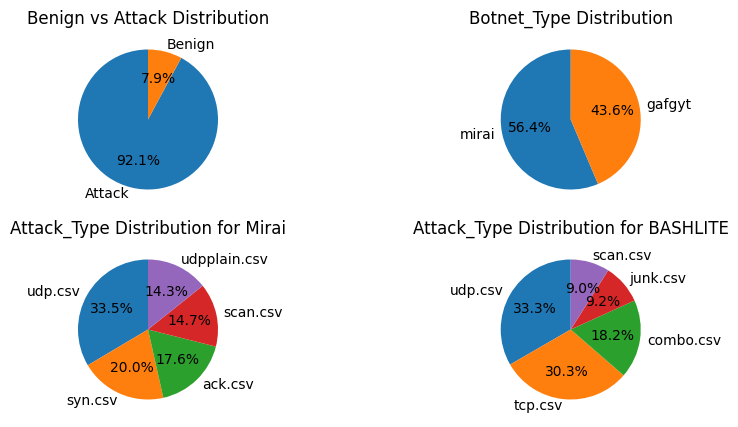

In [8]:
counts = [attack_traffic.shape[0], benign_traffic.shape[0]]
fig, axes = plt.subplots(2, 2, figsize=(10,5))

axes[0][0].pie(counts, labels=["Attack", "Benign"], autopct="%1.1f%%", startangle=90)
axes[0][0].set_title("Benign vs Attack Distribution")


counts = attack_traffic["Botnet_Type"].value_counts()
axes[0][1].pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
axes[0][1].set_title("Botnet_Type Distribution")

counts = attack_traffic[attack_traffic.Botnet_Type == 'mirai']["Attack_Type"].value_counts()
axes[1][0].pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
axes[1][0].set_title("Attack_Type Distribution for Mirai")

counts = attack_traffic[attack_traffic.Botnet_Type == 'gafgyt']["Attack_Type"].value_counts()
axes[1][1].pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
axes[1][1].set_title("Attack_Type Distribution for BASHLITE")
plt.show()